# 네이버 영화평 감성분석 - LSTM

In [1]:
! pip install Konlpy > /dev/null

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 네이버 영화 리뷰 데이터로 검색
train_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', sep='\t')
test_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', sep='\t')

In [4]:
print(train_df.shape, test_df.shape)
train_df.head(3)

(150000, 3) (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


### 1. 데이터 전처리

- train dataset

In [5]:
# Null 데이터가 있는지 확인
train_df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [6]:
# Null 데이터 제거
train_df.dropna(how='any', inplace=True) 
train_df.shape

(149995, 3)

In [7]:
# 중복여부 확인
train_df.document.nunique()

146182

In [8]:
# 중복 데이터 제거
train_df.drop_duplicates(subset=['document'], inplace=True) 
train_df.shape

(146182, 3)

In [9]:
# 긍정(1)/부정(0) 분포
train_df.label.value_counts()

0    73342
1    72840
Name: label, dtype: int64

- test dataset

In [10]:
test_df.isna().sum()

id          0
document    3
label       0
dtype: int64

In [11]:
test_df.dropna(how='any', inplace=True)

In [12]:
test_df.document.nunique()

49157

In [13]:
test_df.drop_duplicates(subset=['document'], inplace=True)
test_df.shape

(49157, 3)

In [14]:
test_df.label.value_counts()

1    24711
0    24446
Name: label, dtype: int64

### 2. 텍스트 전처리
- train dataset

In [15]:
# 한글 이외의 문자는 공백으로 처리하고 strip
train_df.document = train_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
train_df.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [16]:
# '' 만 남은 데이터 --> np.nan 으로 대체한 후 제거
train_df.document.replace('', np.nan, inplace=True)
train_df.document.isna().sum()

789

In [17]:
train_df.dropna(how='any', inplace=True)
train_df.shape

(145393, 3)

- test dataset

In [18]:
test_df.document = test_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
test_df.document.replace('', np.nan, inplace=True)
test_df.dropna(how='any', inplace=True)
test_df.shape

(48852, 3)

### 3. 한글 형태소 분석

In [19]:
from konlpy.tag import Okt
okt = Okt()

In [20]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

In [21]:
from tqdm.notebook import tqdm

X_train = []
for sentence in tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_X = [word for word in morphs if word not in stopwords]
    X_train.append(tmp_X)

  0%|          | 0/145393 [00:00<?, ?it/s]

In [22]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

### 4. Keras TokeniZer --> Train/Test dataset
- 수업중 시간 관계상 train dataset을 train/test dataset으로 분할해서 사용

In [23]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

In [25]:
len(t.word_index)

43118

In [26]:
# 빈도수 상위 20,000개 단어로 인코딩
num_words = 20000
t = Tokenizer(num_words=num_words)
t.fit_on_texts(X_train)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_train, train_df.label.values, stratify=train_df.label.values,
    test_size=0.2, random_state=seed
)

In [28]:
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)

In [29]:
# 데이터의 최대/평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(70, 10.594717746788865)

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_train.shape, X_test.shape

((116314, 40), (29079, 40))

### 5. LSTM 모델 정의/설정/학습

In [31]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [32]:
model = Sequential([ 
    Embedding(num_words, 100, input_length=max_len),
    LSTM(128),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           2000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,117,377
Trainable params: 2,117,377
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])
model_path = 'best-naver-movie-lstm.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=5)

In [34]:
hist = model.fit(
    X_train, y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc, es]
)

Epoch 1/30
720/727 [============================>.] - ETA: 0s - loss: 0.4041 - accuracy: 0.8142
Epoch 1: val_loss improved from inf to 0.36342, saving model to best-naver-movie-lstm.h5
727/727 [==============================] - 15s 9ms/step - loss: 0.4036 - accuracy: 0.8144 - val_loss: 0.3634 - val_accuracy: 0.8388
Epoch 2/30
726/727 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8677
Epoch 2: val_loss improved from 0.36342 to 0.36168, saving model to best-naver-movie-lstm.h5
727/727 [==============================] - 9s 12ms/step - loss: 0.3116 - accuracy: 0.8677 - val_loss: 0.3617 - val_accuracy: 0.8422
Epoch 3/30
725/727 [============================>.] - ETA: 0s - loss: 0.2623 - accuracy: 0.8910
Epoch 3: val_loss did not improve from 0.36168
727/727 [==============================] - 6s 9ms/step - loss: 0.2624 - accuracy: 0.8910 - val_loss: 0.3747 - val_accuracy: 0.8419
Epoch 4/30
724/727 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy:

In [35]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

909/909 [==============================] - 4s 4ms/step - loss: 0.3592 - accuracy: 0.8414


[0.3591746389865875, 0.8413631916046143]

### 6. 실제 데이터 예측

In [36]:
review = '이 영화 개꿀잼 ㅋㅋㅋ'

In [38]:
import re
review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', review).strip()

In [39]:
morphs = okt.morphs(review, stem=True)
morphs = [word for word in morphs if word not in stopwords]
encoded = t.texts_to_sequences([morphs])
padded = pad_sequences(encoded, maxlen=max_len)
score = float(best_model.predict(padded))
print('긍정' if score > 0.5 else '부정')

긍정


In [45]:
def sentiment_predict(review, tokenizer=t, max_len=max_len):
  review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', review).strip()
  morphs = okt.morphs(review, stem=True)
  morphs = [word for word in morphs if word not in stopwords]
  encoded = t.texts_to_sequences([morphs])
  padded = pad_sequences(encoded, maxlen=max_len)
  score = float(best_model.predict(padded))
  return f'긍정({score*100:.2f}%)' if score > 0.5 else f'부정({(1-score)*100:.2f}%)'

In [46]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

'긍정(96.28%)'

In [47]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

'부정(99.27%)'

### 7. 학습과정 시각화

In [52]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
y_vacc = hist.history['val_accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

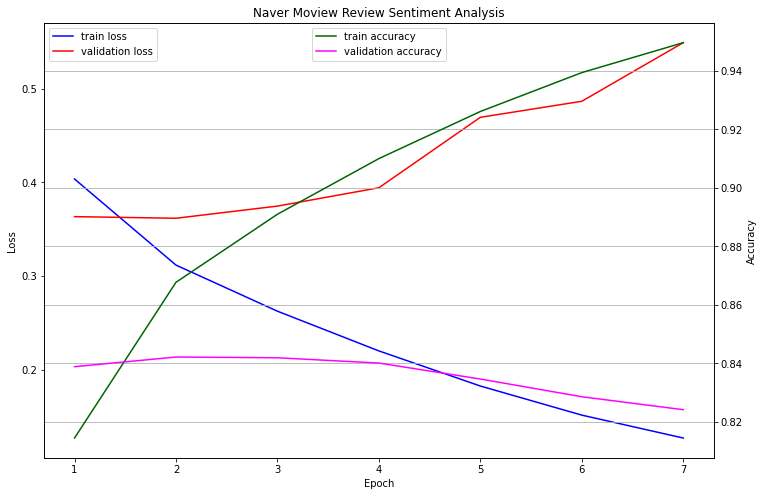

In [53]:
# X축은 공유
# y축은 좌측: loss, y축의 우측: accuracy
import matplotlib.pyplot as plt

fig, ax0 = plt.subplots(figsize=(12, 8))
ax1 = ax0.twinx()
ax0.plot(xs, y_loss, c='blue', label='train loss')
ax0.plot(xs, y_vloss, c='red', label='validation loss')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')
ax1.plot(xs, y_acc, c='darkgreen', label='train accuracy')
ax1.plot(xs, y_vacc, c='magenta', label='validation accuracy')
ax1.set_ylabel('Accuracy')
ax0.legend(loc = 'lower upper'); ax1.legend(loc = 'upper center')
plt.title('Naver Moview Review Sentiment Analysis')
plt.grid(); plt.show()

### 8. Conv1D + GRU

In [54]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dropout

In [55]:
model2 = Sequential([ 
    Embedding(num_words, 120, input_length=max_len),
    Dropout(0.5),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(5),
    GRU(128),
    Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 120)           2400000   
                                                                 
 dropout (Dropout)           (None, 40, 120)           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 64)            38464     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 64)            0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                      

In [57]:
model2.compile('adam', 'binary_crossentropy', ['accuracy'])
model2_path = 'best-naver-movie-conv1d-gru.h5'
mc2 = ModelCheckpoint(model2_path, verbose=1, save_best_only=True)
es2 = EarlyStopping(patience=1)

In [58]:
hist2 = model2.fit(
    X_train, y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc2, es2]
)

Epoch 1/30
727/727 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.7685
Epoch 1: val_loss improved from inf to 0.40670, saving model to best-naver-movie-conv1d-gru.h5
727/727 [==============================] - 16s 9ms/step - loss: 0.4617 - accuracy: 0.7685 - val_loss: 0.4067 - val_accuracy: 0.8078
Epoch 2/30
723/727 [============================>.] - ETA: 0s - loss: 0.3652 - accuracy: 0.8339
Epoch 2: val_loss did not improve from 0.40670
727/727 [==============================] - 5s 7ms/step - loss: 0.3651 - accuracy: 0.8339 - val_loss: 0.4110 - val_accuracy: 0.8089


In [59]:
best_model2 = load_model(model2_path)
best_model2.evaluate(X_test, y_test)

909/909 [==============================] - 3s 3ms/step - loss: 0.4080 - accuracy: 0.8087


[0.40797093510627747, 0.8086591958999634]